# Combination plots

In [1]:
import csv
import os
import warnings
from glob import glob
from textwrap import wrap

import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import regex as re
import scipy.stats as stats
import xarray as xr
import yaml
from attribution.config import init_config
from climix.metadata import load_metadata
from dask.distributed import Client
from tqdm.autonotebook import tqdm

/home/sm_erhol/dev/attribution/attribution/bootstrap.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
index_name = "txge25"

In [3]:
station_far_res = pd.read_csv(f"station_data/data/res/{index_name}_far_boot.csv")

In [4]:
station_far_res.set_index("Unnamed: 0").quantile([0.5], axis=1)

Unnamed: 0,Halmstad flygplats,Kristianstad,Karlshamn,Växjö A,Kalmar flygplats,Göteborg A,Jönköping-Axamos Flygplats,Gladhammar A,Visby Flygplats,Vänersborg,Skara,Linköping-Malmslätt,Örebro Flygplats,Uppsala Aut,Stockholm-Observatoriekullen A
0.5,0.98793,-0.004969,-0.642008,0.873928,0.967447,0.973481,0.992288,0.925699,0.98296,0.995295,0.948805,-3.414245,0.993673,0.933593,0.989715


In [5]:
CFG = init_config("./summer18/config.yml")

Prepare gridded results

In [6]:
data_path = CFG["paths"]["project_folder"]
# Load in the PR arrays
files = [
    f"etc/{index_name}-ann_pbr_gridclim_detrend.npy",
    f"etc/{index_name}-ann_pbr_eobs_detrend.npy",
    f"etc/{index_name}-ann_pbr_era5_detrend.npy",
    f"etc/{index_name}-ann_pbr_cordex_detrend.npy",
    # f"etc/{index_name}-ann_pbr_s-lens_detrend.npy",
]

In [7]:
pbr_data = [np.load(os.path.join(data_path, file)) for file in files]

member_counts = np.asarray(pbr_data[-1:])[:, -1]
grid_far_res = [arr[:5] for arr in pbr_data]
grid_far_res = 1 - 1 / np.asarray(grid_far_res)

grid_labels = [
    "GridClim",
    "EOBS",
    "ERA5",
    f"CORDEX ({member_counts[0]:.0f})",
]

weighted_average = np.average(
    grid_far_res, axis=0, weights=[1e3, 1e3, 1e3, member_counts[0]]
)
weighted_average = weighted_average[np.newaxis, ...]
# Add the weighted average.
grid_far_res = np.concatenate([grid_far_res, weighted_average])
# Add label for average
grid_labels.append("$\\bf{Grid\,Average}$")

Prepare station results

In [8]:
station_far_sel = station_far_res[
    ~station_far_res["Unnamed: 0"].isin(["Karlshamn", "Linköping-Malmslätt", "Kristianstad"])
]

In [9]:
station_far_res = station_far_res.set_index("Unnamed: 0")

In [10]:
station_far_ci = (
    station_far_res
    .quantile([0.05, 0.25, 0.5, 0.75, 0.95], axis=1)
    
).T
mask = station_far_res.index.isin(["Linköping-Malmslätt"])
station_far_sel = station_far_ci[~mask]
station_far_ci = station_far_ci.to_numpy()
station_far_sel = station_far_sel.to_numpy()
station_labels = station_far_res.index.to_numpy()
station_far_ci = np.concatenate(
    [
        station_far_ci,
        np.mean(station_far_ci, axis=0, keepdims=True),
        np.mean(station_far_sel, axis=0, keepdims=True),
    ]
)
station_labels = np.concatenate(
    [station_labels, ["$\\bf{Station\,Average}$", "$\\bf{Adj. Station\,Average}$"]]
)

Combine it

In [11]:
res_to_plot = np.concatenate([station_far_ci, grid_far_res])
labels = np.concatenate([station_labels, grid_labels])

In [12]:
threshold_name = "Summer 2018"

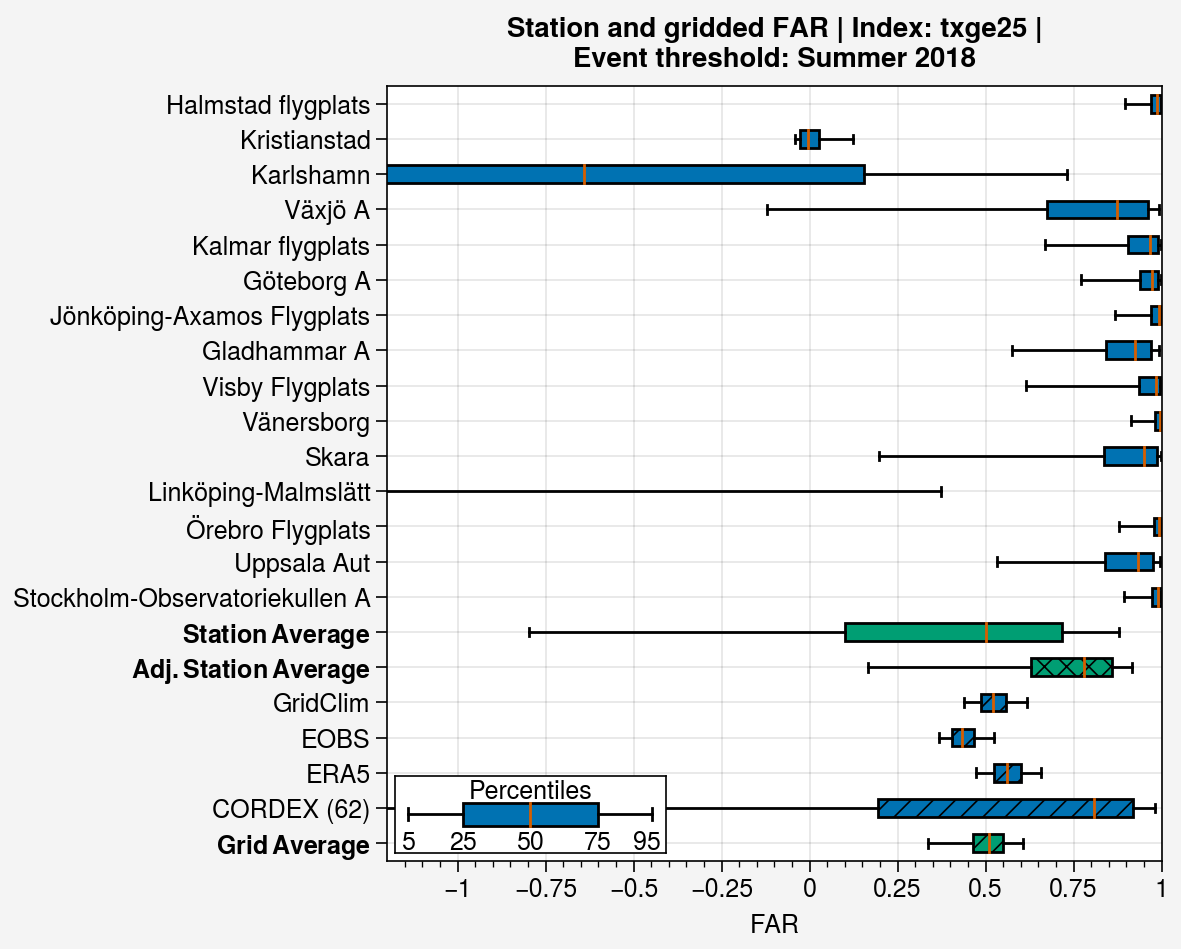

In [13]:
boxes = [
    {
        "label": label,
        "whislo": far[0],
        "q1": far[1],
        "med": far[2],
        "q3": far[3],
        "whishi": far[4],
        "fliers": None,
    }
    for far, label in zip(res_to_plot, labels)
]
fig, ax = pplt.subplots(
    figwidth="15cm",
)
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
# Color grid average
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")
# Color grid
for i in range(5):
    patches["boxes"][i].set_hatch("///")
# Color station averages
patches["boxes"][5].set_color("C2")
patches["boxes"][5].set_edgecolor("k")
patches["boxes"][5].set_hatch("xxx")

patches["boxes"][5].set_edgecolor("k")
patches["boxes"][6].set_color("C2")
patches["boxes"][6].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.1], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xticks=False,
    yticks=False,
    xlim=(0, 100),
)

# Labels
title = "\n".join(
    wrap(
        f"Station and gridded FAR | Index: {index_name} | Event threshold: {threshold_name}",
        45,
    )
)
ax.format(
    xlabel="FAR",
    suptitle=title,
    xreverse=False,
    xlim=(-1.2, 1),
    ytickminor=False,
);

In [14]:
fig.save(f"./plots/{index_name}_combined_far_bar.pdf")

In [16]:
station_far_ci[-2:]

array([[-0.79709153,  0.0999914 ,  0.5002395 ,  0.71585176,  0.88017508],
       [ 0.16641422,  0.62934211,  0.77984552,  0.86043445,  0.91632182]])

In [15]:
grid_far_res

array([[ 0.43981837,  0.48695947,  0.52034428,  0.55841451,  0.61675932],
       [ 0.36651641,  0.40344066,  0.43302117,  0.46569712,  0.52352598],
       [ 0.47347141,  0.52302373,  0.5609742 ,  0.60089131,  0.65830413],
       [-4.06415447,  0.19488624,  0.80861288,  0.91893828,  0.98165525],
       [ 0.33567231,  0.46554762,  0.51093196,  0.5493067 ,  0.60726716]])

## Plots for presentation

In [14]:
grid_far_res

array([[ 0.1737605 ,  0.32465297,  0.45816519,  0.56773263,  0.82022841],
       [ 0.13280182,  0.26165347,  0.40229142,  0.49035455,  0.83515405],
       [ 0.18078274,  0.34315098,  0.4945962 ,  0.59891219,  0.89307525],
       [-3.46278399,  0.18972651,  0.72857051,  0.91951471,  0.99278321],
       [ 0.08904391,  0.30738748,  0.45729072,  0.55976789,  0.85238742]])

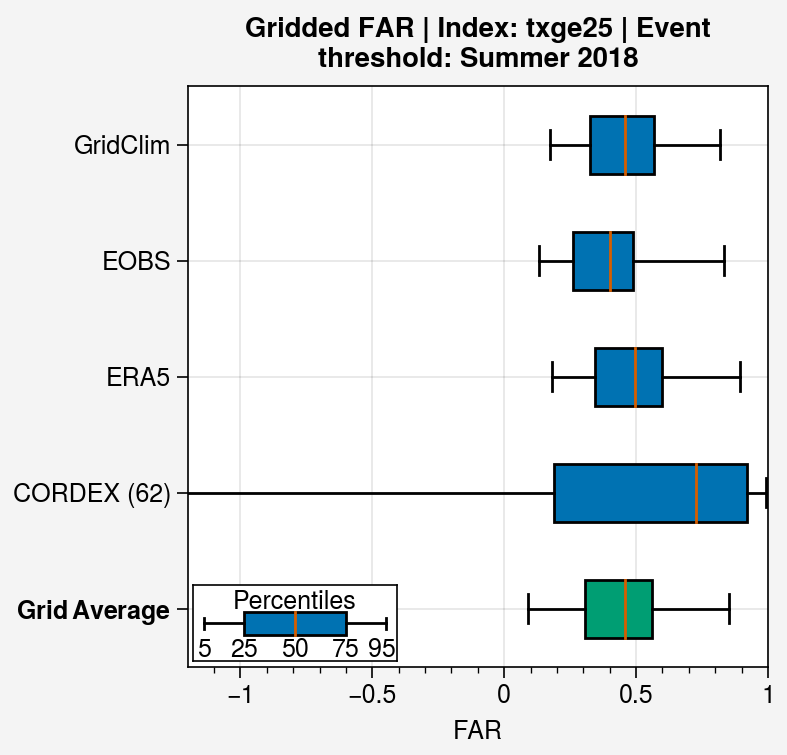

In [28]:
boxes = [
    {
        "label": label,
        "whislo": far[0],
        "q1": far[1],
        "med": far[2],
        "q3": far[3],
        "whishi": far[4],
        "fliers": None,
    }
    for far, label in zip(grid_far_res, grid_labels)
]
fig, ax = pplt.subplots(
    figwidth="10cm",
)
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
# Color grid average
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")
# # Color grid
# for i in range(5):
#     patches["boxes"][i].set_hatch("///")
# # Color station averages
# patches["boxes"][5].set_color("C2")
# patches["boxes"][5].set_edgecolor("k")
# patches["boxes"][5].set_hatch("xxx")
# 
# patches["boxes"][5].set_edgecolor("k")
# patches["boxes"][6].set_color("C2")
# patches["boxes"][6].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.13], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xticks=False,
    yticks=False,
    xlim=(0, 100),
)

# Labels
title = "\n".join(
    wrap(
        f"Gridded FAR | Index: {index_name} | Event threshold: {threshold_name}",
        45,
    )
)
ax.format(
    xlabel="FAR",
    suptitle=title,
    xreverse=False,
    xlim=(-1.2, 1),
    ytickminor=False,
);

In [29]:
fig.save(f"./plots/gridded_far_bar_{index_name}_pres.pdf", facecolor="none")

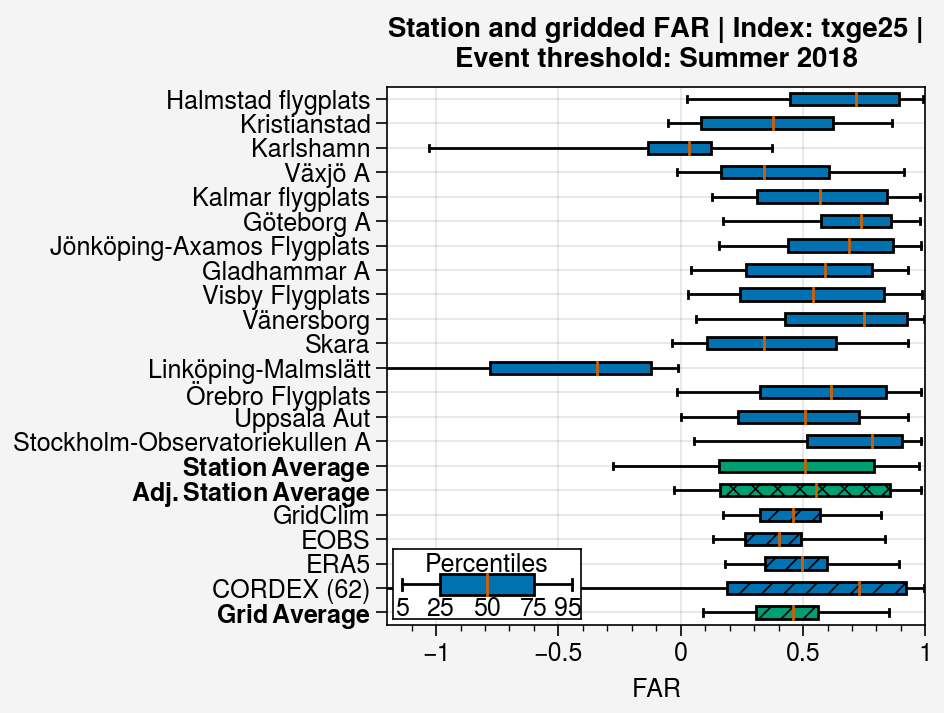

In [35]:
boxes = [
    {
        "label": label,
        "whislo": far[0],
        "q1": far[1],
        "med": far[2],
        "q3": far[3],
        "whishi": far[4],
        "fliers": None,
    }
    for far, label in zip(res_to_plot, labels)
]
fig, ax = pplt.subplots(
    figwidth="12cm",
    # figheight="12cm"
)
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
# Color grid average
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")
# Color grid
for i in range(5):
    patches["boxes"][i].set_hatch("///")
# Color station averages
patches["boxes"][5].set_color("C2")
patches["boxes"][5].set_edgecolor("k")
patches["boxes"][5].set_hatch("xxx")

patches["boxes"][5].set_edgecolor("k")
patches["boxes"][6].set_color("C2")
patches["boxes"][6].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.13], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xticks=False,
    yticks=False,
    xlim=(0, 100),
)

# Labels
title = "\n".join(
    wrap(
        f"Station and gridded FAR | Index: {index_name} | Event threshold: {threshold_name}",
        45,
    )
)
ax.format(
    xlabel="FAR",
    suptitle=title,
    xreverse=False,
    xlim=(-1.2, 1),
    ytickminor=False,
);

In [36]:
fig.save(f"./plots/grid_station_far_bar_{index_name}_pres.pdf", facecolor="none")